In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
from scipy.spatial import procrustes
from scipy.spatial.transform import Rotation as R
import cv2

import SimpleITK as sitk

import ipywidgets
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
pv.set_jupyter_backend("panel")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, affine_transform_volume, \
    affine_transform_point, resample_image

/home/eddyod/programming/pipeline/src


In [4]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()

def get_clockwise_edge_coords(array):
    # Ensure the array is binary (non-zero becomes 1)
    binary = (array > 0).astype(np.uint8)
    
    # Use skimage's find_contours to detect contours at level 0.5
    contours = measure.find_contours(binary, 0.5)

    # If multiple contours, take the largest (most points)
    if not contours:
        return []
    contour = max(contours, key=len)

    # Convert (row, col) to (x, y) and round to int
    coords = np.fliplr(contour).astype(int)

    # Ensure clockwise order using signed area (shoelace formula)
    def is_clockwise(pts):
        return np.sum(
            (pts[1:, 0] - pts[:-1, 0]) * (pts[1:, 1] + pts[:-1, 1])
        ) > 0

    if not is_clockwise(coords):
        coords = coords[::-1]  # Reverse if not clockwise

    return coords


def get_evenly_spaced_vertices(mask, num_points):
    """
    Given a binary mask, extract the outer contour and return evenly spaced vertices along the edge.

    Parameters:
    - mask: 2D numpy array (binary mask)
    - num_points: Number of evenly spaced points to return

    Returns:
    - List of (x, y) coordinates of vertices
    """
    # Ensure mask is uint8
    mask = mask.astype(np.uint8)

    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return []

    # Choose the largest contour (in case there are multiple)
    contour = max(contours, key=cv2.contourArea).squeeze()

    # Calculate arc length (perimeter)
    arc_length = cv2.arcLength(contour, True)
    print(arc_length)

    # Calculate the cumulative arc lengths
    distances = [0]
    for i in range(1, len(contour)):
        d = np.linalg.norm(contour[i] - contour[i - 1])
        distances.append(distances[-1] + d)
    distances = np.array(distances)

    # Sample points at regular intervals
    desired_distances = np.linspace(0, distances[-1], num_points, endpoint=False)
    vertices = []
    j = 0
    for d in desired_distances:
        while j < len(distances) - 1 and distances[j+1] < d:
            j += 1
        # Linear interpolation between points j and j+1
        t = (d - distances[j]) / (distances[j+1] - distances[j])
        pt = (1 - t) * contour[j] + t * contour[j + 1]
        vertices.append(tuple(pt.astype(int)))

    return vertices



In [171]:
def center_images_to_largest_volume(images):
    """
    Centers a list of 3D SimpleITK images using the largest-volume image as the reference.

    Parameters:
        images (List[sitk.Image]): List of 3D SimpleITK Image objects.

    Returns:
        List[sitk.Image]: List of centered images (same order as input).
    """
    if not images:
        raise ValueError("No images provided.")

    # Compute volumes and find reference image
    volumes = [img.GetSize()[0] * img.GetSize()[1] * img.GetSize()[2] * 
               img.GetSpacing()[0] * img.GetSpacing()[1] * img.GetSpacing()[2] for img in images]
    reference_index = volumes.index(max(volumes))
    reference_image = images[reference_index]

    """
    ref_center = sitk.PhysicalPointSource(reference_image.GetPixelID(), reference_image.GetSize(), reference_image.GetOrigin(),
                                          reference_image.GetSpacing(), reference_image.GetDirection())
    ref_center = sitk.CenteredTransformInitializer(reference_image, reference_image,
                                                   sitk.Euler3DTransform(), 
                                                   sitk.CenteredTransformInitializerFilter.MOMENTS).GetTranslation()

    """
    centered_images = []
    for i, img in enumerate(images):
        if i == reference_index:
            centered_images.append(img)
            continue

        # Calculate center transform
        transform = sitk.CenteredTransformInitializer(reference_image, img,
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

        # Resample image
        resampled = sitk.Resample(img,
                                  reference_image,
                                  transform,
                                  sitk.sitkLinear,
                                  0.0,
                                  img.GetPixelID())

        centered_images.append(resampled)

    return centered_images


def resize_image(image, new_size):
    """
    Resamples an image to match the reference image in size, spacing, and direction.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)  # Linear interpolation for resampling
    resampler.SetDefaultPixelValue(0)  # Fill with zero if needed
    resultImage = resampler.Execute(image)
    #return sitk.GetArrayFromImage(resultImage)
    return resultImage


def load_volumes(structure):
    images = []

    brains = ['MD585', 'MD589', 'MD594']
    for brain in brains:
        structure_path = os.path.join(data_path, brain, 'structure', f'{structure}.npy')
        arr = np.load(structure_path)
        arr = arr.astype(np.float32)
        print(arr.dtype, arr.shape)
        arr = sitk.GetImageFromArray(arr, isVector=False)
        images.append(arr)

    sizes = [img.GetSize() for img in images]
    max_size = np.max(sizes, axis=0)
        
    resampled_images = [resize_image(img, max_size.tolist()) for img in images]
    reference_image = max(resampled_images, key=lambda img: np.prod(img.GetSize()))
    resampled_images = center_images_to_largest_volume(resampled_images)
    resampled_images = align_images_to_common_center(resampled_images)
    
    return resampled_images, reference_image
        #return [sitk.ReadImage(p, sitk.sitkFloat32) for p in volume_paths]

def get_image_center(image):
    """Compute the physical center of a SimpleITK image."""
    size = np.array(image.GetSize())
    spacing = np.array(image.GetSpacing())
    origin = np.array(image.GetOrigin())
    direction = np.array(image.GetDirection()).reshape(3, 3)
    
    center_index = (size - 1) / 2.0
    center_physical = origin + direction @ (center_index * spacing)
    
    return center_physical

def compute_translation_transform(from_center, to_center):
    """Create a translation transform that moves from_center to to_center."""
    translation_vector = to_center - from_center
    return sitk.TranslationTransform(3, translation_vector)

def align_images_to_common_center(images):
    """
    Given a list of SimpleITK 3D images, return a list of translated images
    aligned to their common center.
    """
    centers = [get_image_center(img) for img in images]
    common_center = np.mean(centers, axis=0)
    print('common center via mean', common_center)
    

    aligned_images = []

    for img, center in zip(images, centers):
        transform = compute_translation_transform(center, common_center)
        resampled = sitk.Resample(
            img,
            img.GetSize(),
            transform,
            sitk.sitkLinear,
            img.GetOrigin(),
            img.GetSpacing(),
            img.GetDirection(),
            0.0,  # default pixel value
            img.GetPixelID()
        )
        aligned_images.append(resampled)
    
    return aligned_images



In [172]:
#aligned_volumes, final_average = groupwise_register_and_align()
structure = '10N_R'
structure = 'SC'
aligned_volumes, final_average = load_volumes(structure)

float32 (211, 179, 362)
float32 (229, 148, 364)
float32 (195, 195, 338)
max size [364 195 229] <class 'numpy.ndarray'>
common center via mean [181.5  97.  114. ]


In [173]:
avg_volume = np.mean([sitk.GetArrayFromImage(vol) for vol in aligned_volumes], axis=0)
print(avg_volume.dtype, avg_volume.shape)

float32 (229, 195, 364)


midpoint= 182


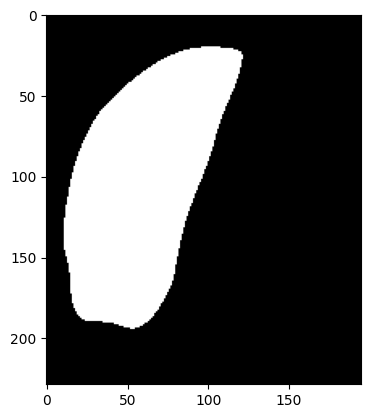

In [177]:
arr = avg_volume.copy()
z = arr.shape[2] // 2
print('midpoint=',z)
volume = arr.copy()
volume = adjust_volume(volume, 255)
slice = volume[:,:,z]
plt.imshow(slice, cmap='gray')

MD585 uint8 (211, 179, 362) (100.3798535244159, 79.72296577239838, 184.92438814497962)
MD589 uint8 (229, 148, 364) (121.4576844596818, 66.9133833710765, 175.2829096439005)
MD594 uint8 (195, 195, 338) (91.0010239423265, 84.61523041616576, 165.0117223517259)


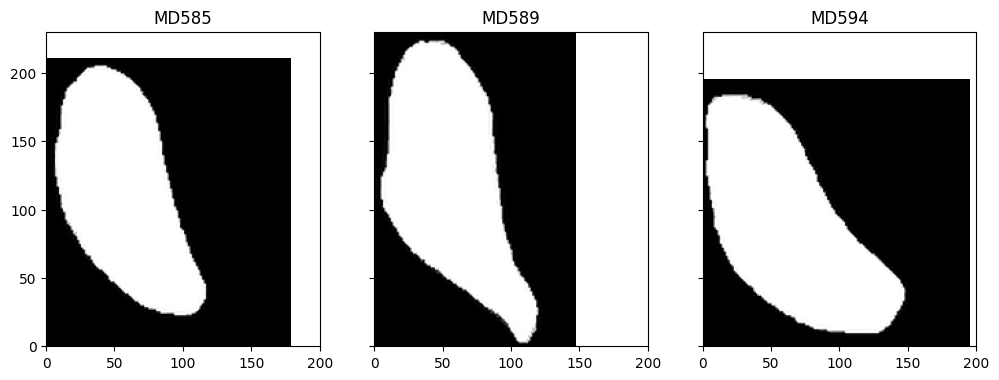

In [29]:
volumes = []

brains = ['MD585', 'MD589', 'MD594']
for brain in brains:
    structure_path = os.path.join(data_path, brain, 'structure', f'{structure}.npy')
    arr = np.load(structure_path)
    com = center_of_mass(arr)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')
    volumes.append(arr)

_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(volumes, axs, brains):
    z = img.shape[2] // 2
    slice = img[:,:,z].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 200)
    ax.set_ylim(0,230)
    ax.imshow(slice, cmap="gray")
plt.show()

MD585 float32 (229, 195, 364) (100.3799479848029, 79.72304079404799, 184.92456216425396)
MD589 float32 (229, 195, 364) (100.68370699798973, 79.61749830650437, 184.60230099133855)
MD594 float32 (229, 195, 364) (100.29354135170851, 79.90216220410896, 184.93948827440212)


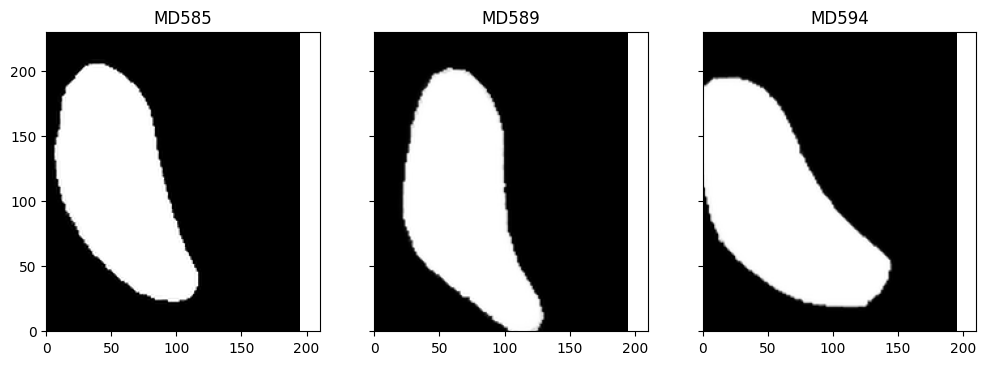

In [175]:
_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(aligned_volumes, axs, brains):
    img = sitk.GetArrayFromImage(img)
    com = center_of_mass(img)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')
    z = img.shape[2] // 2
    slice = img[:,:,z].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 210)
    ax.set_ylim(0,230)
    ax.imshow(slice, cmap="gray")
plt.show()

MD594 float32 (211, 179, 362) (117.96117353399846, 86.11990402115781, 168.9747140833126)
MD594 float32 (211, 179, 362) (108.96931582445244, 77.39028854209255, 176.70899107749185)
MD594 float32 (211, 179, 362) (107.68123983085128, 76.35476026102747, 179.81073517802304)


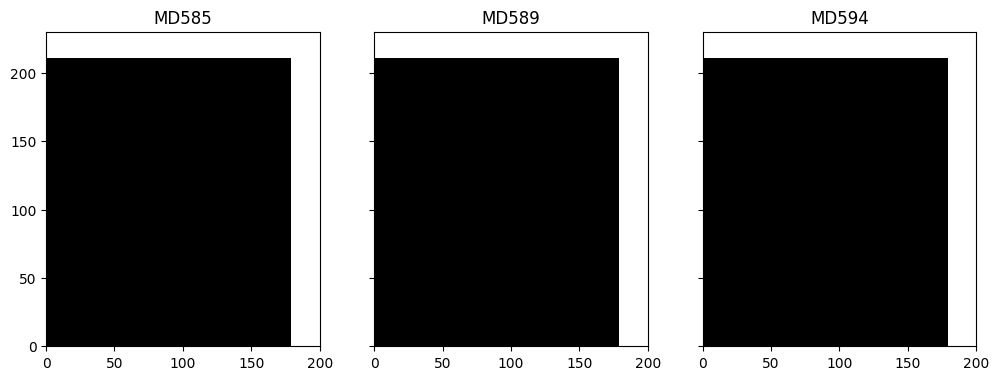

In [52]:
volumes = []
for volume in registered_images:
    arr = sitk.GetArrayFromImage(volume)
    com = center_of_mass(arr)
    print(f'{brain} {arr.dtype} {arr.shape} {com}')
    volumes.append(arr)
_, axs = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for img, ax, brain in zip(volumes, axs, brains):
    z = img.shape[2] // 2
    slice = img[:,:,-10].astype(np.uint8)
    ax.set_title(brain)
    ax.set_xlim(0, 200)
    ax.set_ylim(0,230)
    ax.imshow(slice, cmap="gray")
plt.show()

In [ ]:
animal = 'AtlasV8'
structure_path = os.path.join(data_path, animal, 'structure', f'{structure}.npy')
arr = np.load(structure_path)
ids, counts = np.unique(arr, return_counts=True)
if len(ids) < 10:
    print(ids)
    print(counts)
print(arr.shape, arr.dtype, np.mean(arr), np.min(arr), np.max(arr))

In [ ]:
z = arr.shape[2] // 2
volume = arr.copy()
#volume = adjust_volume(volume, 255)
#slice = volume[:,:,z].astype(np.uint32)
slice = volume[:,:,z]
plt.imshow(slice, cmap='gray')

In [ ]:
z = arr.shape[2] // 2
volume = arr.copy()
volume = adjust_volume(volume, 255)
slice = volume[:,:,z].astype(np.uint32)
plt.imshow(slice, cmap='gray')

In [ ]:
adjusted = adjust_volume(volume, 255)
slice = adjusted[:,:,z].astype(np.uint32)
plt.imshow(slice, cmap='gray')

In [ ]:
#n, nl, vertices = get_outer_edge_vertices(slice)
vertices = get_evenly_spaced_vertices(slice, 20)
# Visualize result
plt.imshow(slice, cmap='gray')
x, y = zip(*vertices)
plt.plot(x, y, 'r-')
plt.scatter(x, y, c='blue')
plt.title("Contour Vertices")
plt.show()

In [ ]:
slice = volume[:,:,z].astype(np.uint32)
print(volume.shape)



In [ ]:
data = pv.wrap(volume)
data.plot(volume=True) # Volume render

In [ ]:
#transformed_volume = affine_transform_volume(volume, transformation_matrix)
# Visualize original and transformed volumes
visualize_slices(volume, title="Original Volume")
#visualize_slices(transformed_volume, title="Transformed Volume")

In [ ]:
# Visualize original and transformed volumes
transformed_volume = affine_transform_volume(volume, transformation_matrix)
visualize_slices(transformed_volume, title="Transformed Volume")